# <u>*Agenda*<u/>

In this project, we’re going to build an LSTM (Long Short-Term Memory) Autoencoder to spot unusual spikes or drops in the S&P 500 Index over a span of 34 years. Here’s a breakdown of the steps we’ll follow to detect those sneaky anomalies in the stock market!

---

## 1. **Project overvieww**
We aim to:
- **Create** a model using Keras that learns patterns in the S&P 500 stock index.
- **Detect** sudden, unexpected price changes (anomalies) that could be valuable insights.
- **Use** the historical stock data from 1986 to 2020.

---

## 2. **Load and Inspect the Data**
First, we load the data (usually in CSV format) with important details:
- **Timestamps** for daily stock values
- **Open, Close, High, and Low Prices** 
- **Volume of trades**


| Date       | Open  | Close | High  | Low   | Volume |
|------------|-------|-------|-------|-------|--------|
| 1986-01-01 | 200.5 | 205.3 | 207.5 | 200.0 | 5M     |
| 1986-01-02 | 205.3 | 210.1 | 212.0 | 204.5 | 4.7M   |

---

## 3. **Dtaaa Preprocessing**
Now we clean the data:
- Handle any missing values
- Scale the data to make it easier for the model to learn patterns
- Normalize prices and volumes to fit the LSTM requirements

---

## 4. **Temporalize the Data & Train-Test Split**
We’ll break the data into sequences, focusing on **past values** to predict future ones. Then, we split it into **training** and **testing** sets to evaluate the model’s performance.

---

## 5. **Build the LSTM Autoencoder**
The core of the model is the LSTM Autoencoder:
- LSTMs capture long-term dependencies in time series data.
- The Autoencoder learns to compress and reconstruct the data, which helps detect anomalies when reconstruction errors are too large.

---

## 6. **Train the Autoencoder**
We train the model to:
- Learn the normal price movements of the S&P 500.
- Minimize reconstruction errors by comparing the predicted values to the actual values.

---

## 7. **Plot Metrics and Evaluate the Model**
During training, we’ll plot:
- **Loss curves** to see how well the model is learning.
- **Accuracy metrics** to evaluate how well it performs on unseen data.

---

## 8. **Detect Anomalies in the data**
Once trained, we pass the test data through the model:
- If the reconstruction error is **too high**, it signals an anomaly.
- We’ll look for sudden, sharp price movements that don’t fit the normal patterns.

---

## 9. **Visualize the Anomalies**
Finally, we’ll visualize the results:
- **Plot the price data** along with **highlighted anomalies** on a graph.
- Use **thresholds** to clearly mark where those unexpected price shifts happened.

---

With this approach, you’ll have a robust anomaly detection system that helps pinpoint weird behavior in the data 📈



# Loadind Dependencies

In [1]:
#Libraries Needed 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from keras.models import Sequential
from keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


In [2]:
np.random.seed(1)
tf.random.set_seed(1)
pd.options.mode.chained_assignment = None #remove warnings
sns.set(style = 'whitegrid', palette = 'muted')

print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.17.1


# Loading the Dataset

In [3]:
df = pd.read_csv('/kaggle/input/financial-stock-market-data/Stock_Market_Time_Series_Data.csv', parse_dates = ['Date'] )
df.head() 

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-01-02,211.279999,211.279999,208.929993,209.589996,209.589996,98960000
1,1986-01-03,209.589996,210.880005,209.509995,210.880005,210.880005,105000000
2,1986-01-06,210.880005,210.979996,209.929993,210.649994,210.649994,99610000
3,1986-01-07,210.649994,213.800003,210.649994,213.800003,213.800003,153000000
4,1986-01-08,213.800003,214.570007,207.490005,207.970001,207.970001,180300000


In [4]:
#We are only interested in Date and Close columns. Lets drop the rest
df = df.drop(['Open', 'Adj Close', 'High', 'Volume', 'Low'], axis = 1) 
df.head() 

,Date,Close
0,1986-01-02,209.589996
1,1986-01-03,210.880005
2,1986-01-06,210.649994
3,1986-01-07,213.800003
4,1986-01-08,207.970001


In [5]:
df.shape #Lets check dataset shape

(8678, 2)

# Visualize Trend

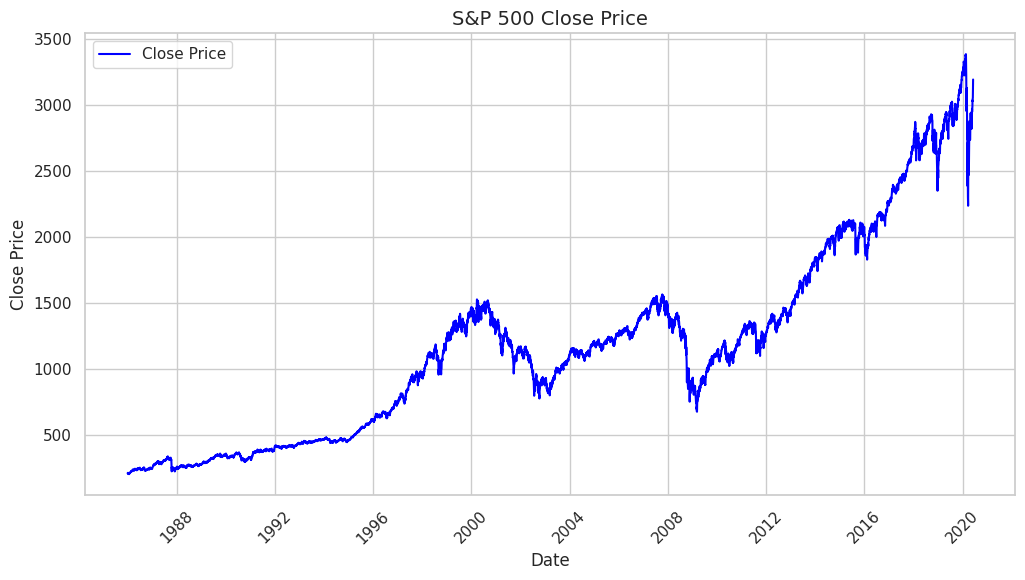

In [6]:
# Plot the closing prices to visualize the trend
def plot_close_prices():
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
    plt.title("S&P 500 Close Price", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Close Price", fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

plot_close_prices()

# Data Preprocessing

In [7]:
# Data preprocessing
train_size = int(len(df) * 0.80)
train, test = df.iloc[:train_size], df.iloc[train_size:]
scaler = StandardScaler()
scaler.fit(train[['Close']])
train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

# Data Splitting

In [8]:
# Create sequences for LSTM input
def create_sequence(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:i+time_steps].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


In [9]:
X_train, y_train = create_sequence(train[['Close']], train.Close, time_steps=30)
X_test, y_test = create_sequence(test[['Close']], test.Close, time_steps=30)

# Building the LSTM

In [10]:
# Build LSTM Autoencoder model
def LSTM_Autoencoder(timesteps, n_features):
    model = Sequential()
    model.add(LSTM(128, input_shape=(timesteps, n_features)))
    model.add(Dropout(0.2))
    model.add(RepeatVector(timesteps))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(loss='mae', optimizer='adam')
    return model

In [11]:
timesteps = X_train.shape[1]
n_features = X_train.shape[2]
model = LSTM_Autoencoder(timesteps, n_features)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 1)               │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

# Training the model

In [12]:
# Train the model
ES = EarlyStopping(monitor='val_loss', patience=10, mode='min')
MC = ModelCheckpoint('/kaggle/working/best_model.keras', monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, callbacks=[ES, MC], shuffle=False)


Epoch 1/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.2781 - val_loss: 0.1334
Epoch 2/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1674 - val_loss: 0.0827
Epoch 3/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1245 - val_loss: 0.0884
Epoch 4/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1501 - val_loss: 0.0776
Epoch 5/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1391 - val_loss: 0.0782
Epoch 6/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1475 - val_loss: 0.0785
Epoch 7/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1659 - val_loss: 0.0856
Epoch 8/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1753 - val_loss: 0.0827
Epoch 9/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1669 - val_loss: 0.0927
Epoch 10/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1766 - val_loss: 0.0865
Epoch 11/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1903 - val_loss: 0.1153
Epoch 12/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 

# Evaluation

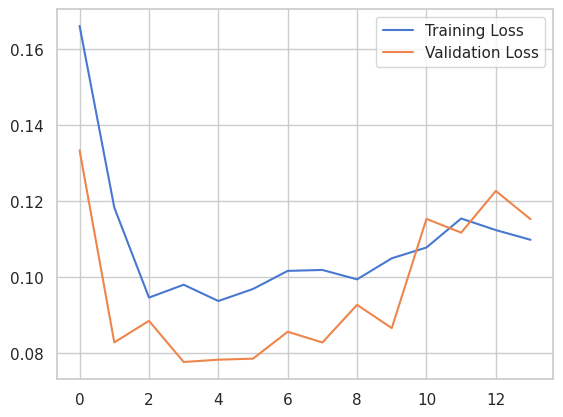

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3662
 1/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

<ipython-input-13-c76a944f5aa0>:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins = 50, kde = True)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


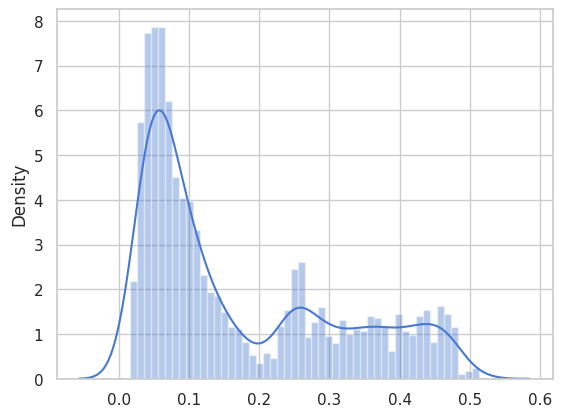

In [13]:
def trainloss_valloss():
    #Lets plot training and validation loss using matplotlib
    #The loss values are stored in history.history (dictionary)
    plt.plot(history.history['loss'], label = 'Training Loss') #Plotting training loss
    plt.plot(history.history['val_loss'], label = 'Validation Loss') #Plotting validation loss
    plt.legend() #Using labels as legend
    #If validation loss is lower than Training loss, it means the model is underfitting. 
    #If validation loss is higher than Training loss, it means the model is overfititng
    return plt.show()

trainloss_valloss() #Plot

#Load the best model observed as saved_model
saved_model = load_model('best_model.keras')


X_train_pred = saved_model.predict(X_train) #Model prediction on training data

#Save Mean Absolute Error to a pandas DataFrame in the Column 'Error'
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis = 1), columns = ['Error'])

#Evaluate the best model, saved_model on test data for total loss. 
saved_model.evaluate(X_test, y_test)

#Lets plot the distribution plot for MAE Loss Error using seaborn
sns.distplot(train_mae_loss, bins = 50, kde = True)

#Lets set a threshold for the MAE Loss. If error is larger, it will be predicted as an anomaly
threshold = 0.50 #This is the value that decides a data point is an anomaly or not. 

#Predict X_test
X_test_pred = saved_model.predict(X_test)

#Store MAE Loss for test data
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis = 1)


# Anomaly Visulization

In [14]:
test_score_df = pd.DataFrame(test[timesteps:]) #We use the data that comes after time_steps in test data
test_score_df['loss'] = test_mae_loss #Create test_mae_loss column
test_score_df['threshold'] = threshold #Create threshold column
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold #Set anomaly as True if
test_score_df['Close'] = test[timesteps:].Close

#Lets see the newly created DataFrame
test_score_df.head()

#Show the last entries in the dataframe
test_score_df.tail()

def testloss_threshold():
    #Lets create an interactive chart with plotly to show data with anomalies
    fig = go.Figure() #Empty figure
    #Create lineplot with x-axis as values after timesteps and y-axis as loss values.
    fig.add_trace(go.Scatter(x = test[timesteps:].Date, y = test_score_df.loss,
                            mode = 'lines', name = 'Test Loss')) 
    
    #Create lineplot with x-axis as values after timesteps and y-axis as threshold.
    fig.add_trace(go.Scatter(x = test[timesteps:].Date, y = test_score_df.threshold,
                            mode = 'lines', name = 'Threshold')) 
    
    fig.update_layout(showlegend = True) #Add legend to plot
    
    return fig.show()

testloss_threshold() #Plot

#Lets create a DataFrame for all Anomalies. 
#We create a DataFrame only from True values in the anomaly column
anomalies = test_score_df[test_score_df.anomaly == True] 
anomalies.head()

def show_anomalies():
    # Lets create an interactive chart with plotly to show anomalies
    fig = go.Figure()  # Empty figure
    
    # Create lineplot with x-axis as test values after timesteps and y-axis as closing price.
    fig.add_trace(go.Scatter(x = test[timesteps:].Date, 
                            y = scaler.inverse_transform(test[timesteps:].Close.values.reshape(-1, 1)),  # Reshaped to 2D
                            mode = 'lines', name = 'Close Price')) 
    
    # Create lineplot with x-axis as anomaly dates. y-axis as anomaly price.
    # We use mode = markers to plot a scatter plot
    fig.add_trace(go.Scatter(x = anomalies.Date, 
                            y = scaler.inverse_transform(anomalies.Close.values.reshape(-1, 1)),  # Reshaped to 2D
                            mode = 'markers', name = 'Anomaly')) 
    
    fig.update_layout(showlegend = True)  # Add legend to plot
    fig.show()
    return plt.show()


In [15]:
print(anomalies.head())  # Check if anomalies are present


           Date     Close      loss  threshold  anomaly
7475 2015-08-26  2.481280  0.515299        0.5     True
7476 2015-08-27  2.591172  0.520978        0.5     True
7861 2017-03-09  3.470328  0.505391        0.5     True
7862 2017-03-10  3.488344  0.514607        0.5     True
7863 2017-03-13  3.490371  0.522599        0.5     True


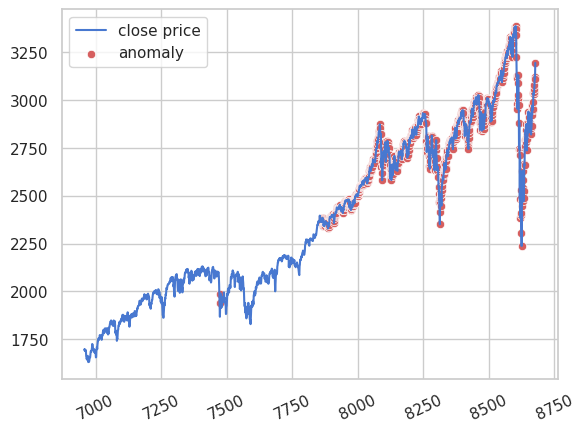

In [16]:
anomalies_close = anomalies[["Close"]].values.flatten()
anomalies_close = anomalies_close.reshape(-1, 1) # Reshape to a 2D array
anomalies_close = scaler.inverse_transform(anomalies_close)

time_steps=15
plt.plot(test[time_steps:].index, 
         scaler.inverse_transform(test[time_steps:][["Close"]]), 
         label='close price')

# convert it to a 1D array for the plot
anomalies_close = anomalies_close.flatten()
sns.scatterplot(x=anomalies.index, 
                y=anomalies_close, 
                color=sns.color_palette()[3], 
                label='anomaly'
               )

plt.xticks(rotation=25) 
plt.legend()
